In [8]:
import sys
sys.path.append("../../../../src")
sys.path.append("../../")
import os
import numpy as np
import pickle
from example_lorenz import get_lorenz_data, generate_lorenz_data
from autoencoder import full_network
from training import create_feed_dictionary
from sindy_utils import sindy_simulate
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [9]:
data_path_original = '../../sindy_models/original/'
data_path_verification = '../../sindy_models/verification/'

save_names = {
    data_path_original + 'model1': 'O1',
    data_path_original + 'model2': 'O2', 
}

for i in range(1, 11):
    save_names[data_path_verification + f'V{i}'] = f'V{i}'

## Single trajectory plots

In [10]:
z_sims = []

for i, save_name in enumerate(save_names.keys()):
    tf.compat.v1.reset_default_graph()
    data_path = os.getcwd() + '/'
    params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
    params['save_name'] = data_path + save_name

    autoencoder_network = full_network(params)
    learning_rate = tf.compat.v1.placeholder(tf.float32, name='learning_rate')
    saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

    tensorflow_run_tuple = ()
    for key in autoencoder_network.keys():
        tensorflow_run_tuple += (autoencoder_network[key],)

    t = np.arange(0,20,.01)
    z0 = np.array([[-8,7,27]])

    test_data = generate_lorenz_data(z0, t, params['input_dim'], linear=False, normalization=np.array([1/40,1/40,1/40]))
    test_data['x'] = test_data['x'].reshape((-1,params['input_dim']))
    test_data['dx'] = test_data['dx'].reshape((-1,params['input_dim']))
    test_data['z'] = test_data['z'].reshape((-1,params['latent_dim']))
    test_data['dz'] = test_data['dz'].reshape((-1,params['latent_dim']))

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, data_path + save_name)
        test_dictionary = create_feed_dictionary(test_data, params)
        tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

    test_set_results = {}
    for i,key in enumerate(autoencoder_network.keys()):
        test_set_results[key] = tf_results[i]

    z_sims.append(sindy_simulate(test_set_results['z'][0], t, params['coefficient_mask']*test_set_results['sindy_coefficients'], params['poly_order'], params['include_sine']))
    # print(test_set_results['z'][0])

lsim = sindy_simulate(test_data['z'][0], t, test_data['sindy_coefficients'], params['poly_order'], params['include_sine'])

INFO:tensorflow:Restoring parameters from /home/paulsaegert/Documents/git/sindy-autoencoders-improvements/original/examples-verification/lorenz/analysis/verification/../../sindy_models/original/model1
INFO:tensorflow:Restoring parameters from /home/paulsaegert/Documents/git/sindy-autoencoders-improvements/original/examples-verification/lorenz/analysis/verification/../../sindy_models/original/model2
INFO:tensorflow:Restoring parameters from /home/paulsaegert/Documents/git/sindy-autoencoders-improvements/original/examples-verification/lorenz/analysis/verification/../../sindy_models/verification/V1
INFO:tensorflow:Restoring parameters from /home/paulsaegert/Documents/git/sindy-autoencoders-improvements/original/examples-verification/lorenz/analysis/verification/../../sindy_models/verification/V2
INFO:tensorflow:Restoring parameters from /home/paulsaegert/Documents/git/sindy-autoencoders-improvements/original/examples-verification/lorenz/analysis/verification/../../sindy_models/verificatio

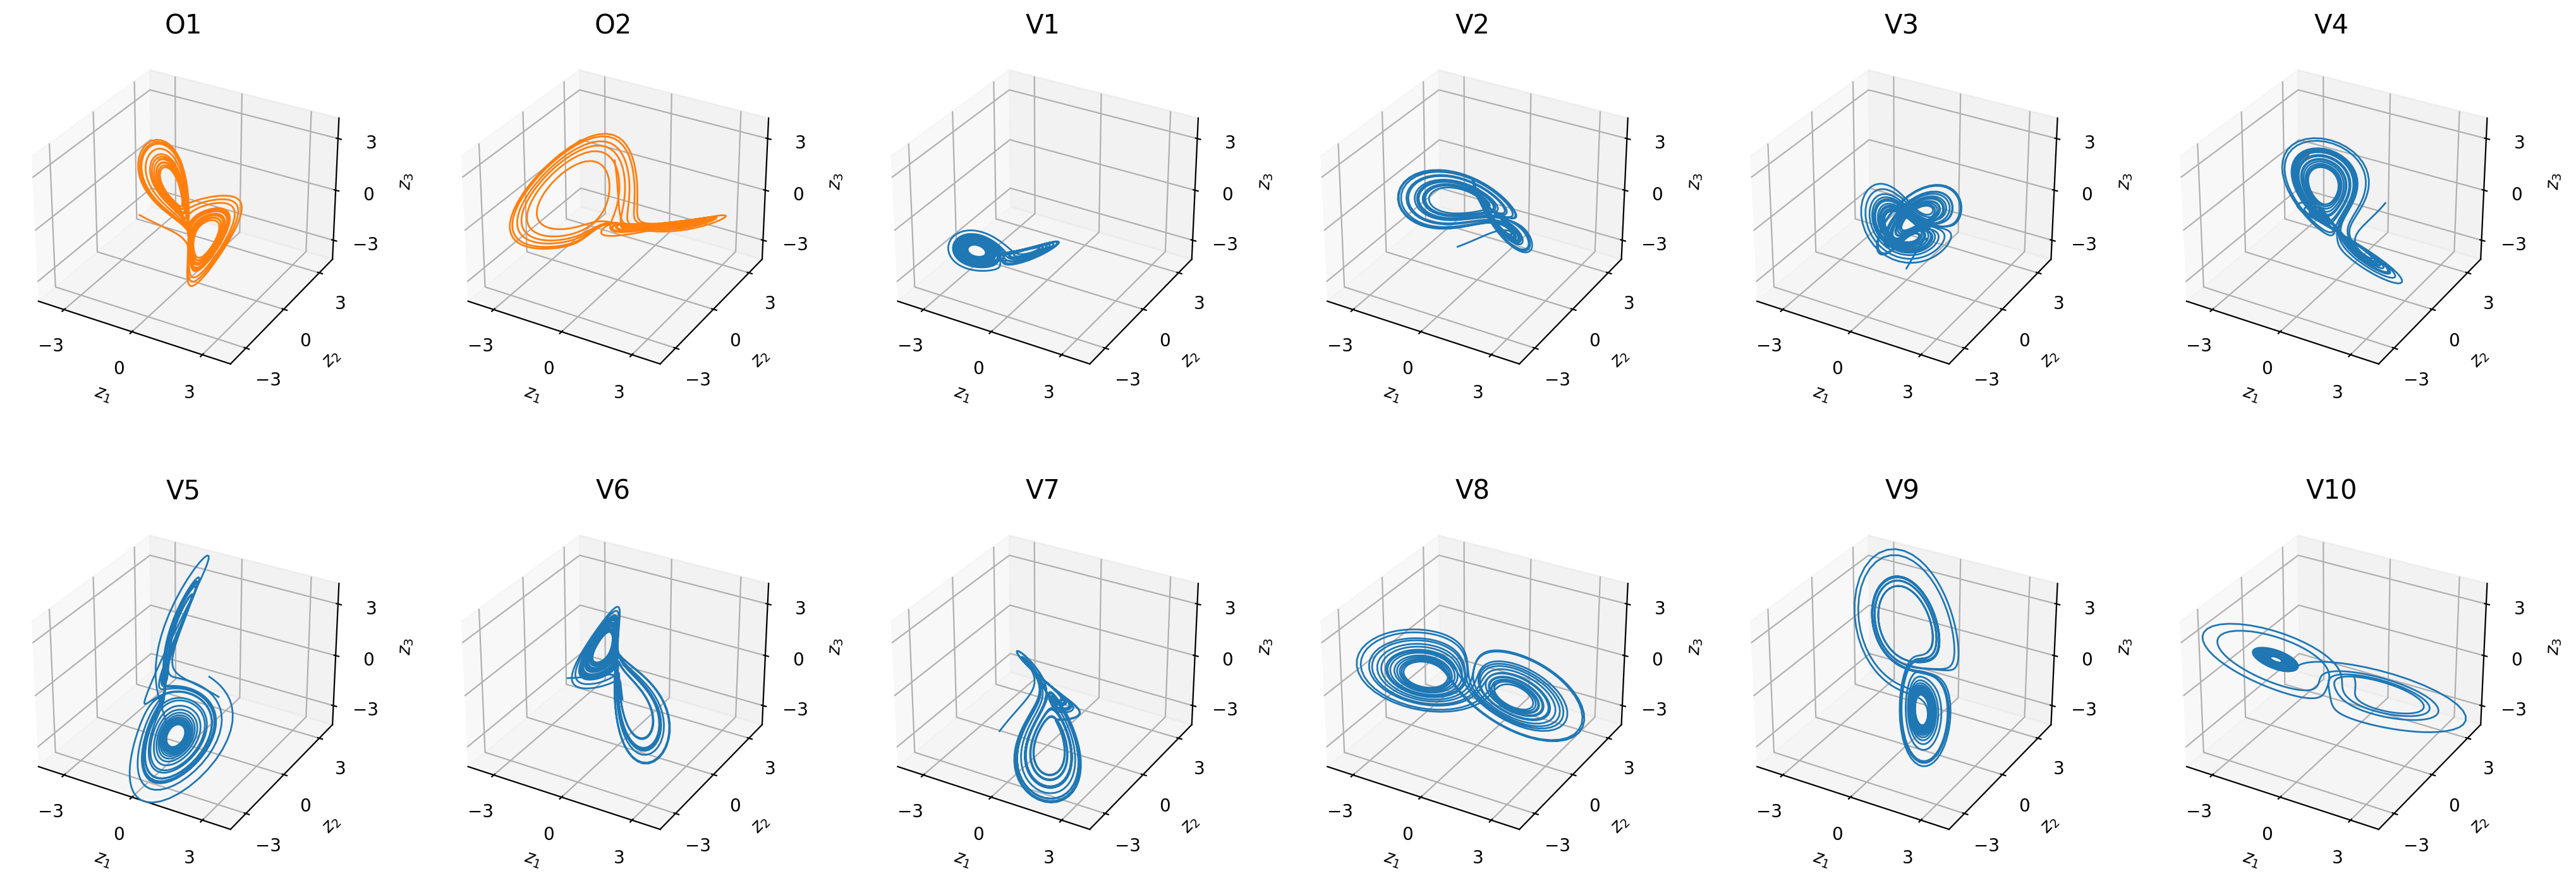

In [11]:
fig = plt.figure(figsize=(20, 15), dpi=200)
axes = []

for i, ((k, v), zsim) in enumerate(zip(save_names.items(), z_sims)):
    axes.append(fig.add_subplot(4, 6, i+1, projection='3d'))
    axes[i].plot(zsim[:,0], zsim[:,1], zsim[:,2], linewidth=1, color='tab:orange' if 'O' in v else None)
    axes[i].set_xlabel(r'$z_1$'); axes[i].set_ylabel(r'$z_2$'); axes[i].set_zlabel(r'$z_3$'); axes[i].set_title(v, fontsize=15)
    axes[i].set_xlim(-4, 4); axes[i].set_ylim(-4, 4); axes[i].set_zlim(-4, 4);
    axes[i].set_xticks([-3, 0, 3]); axes[i].set_yticks([-3, 0, 3]); axes[i].set_zticks([-3, 0, 3]);

fig.tight_layout(w_pad=5)

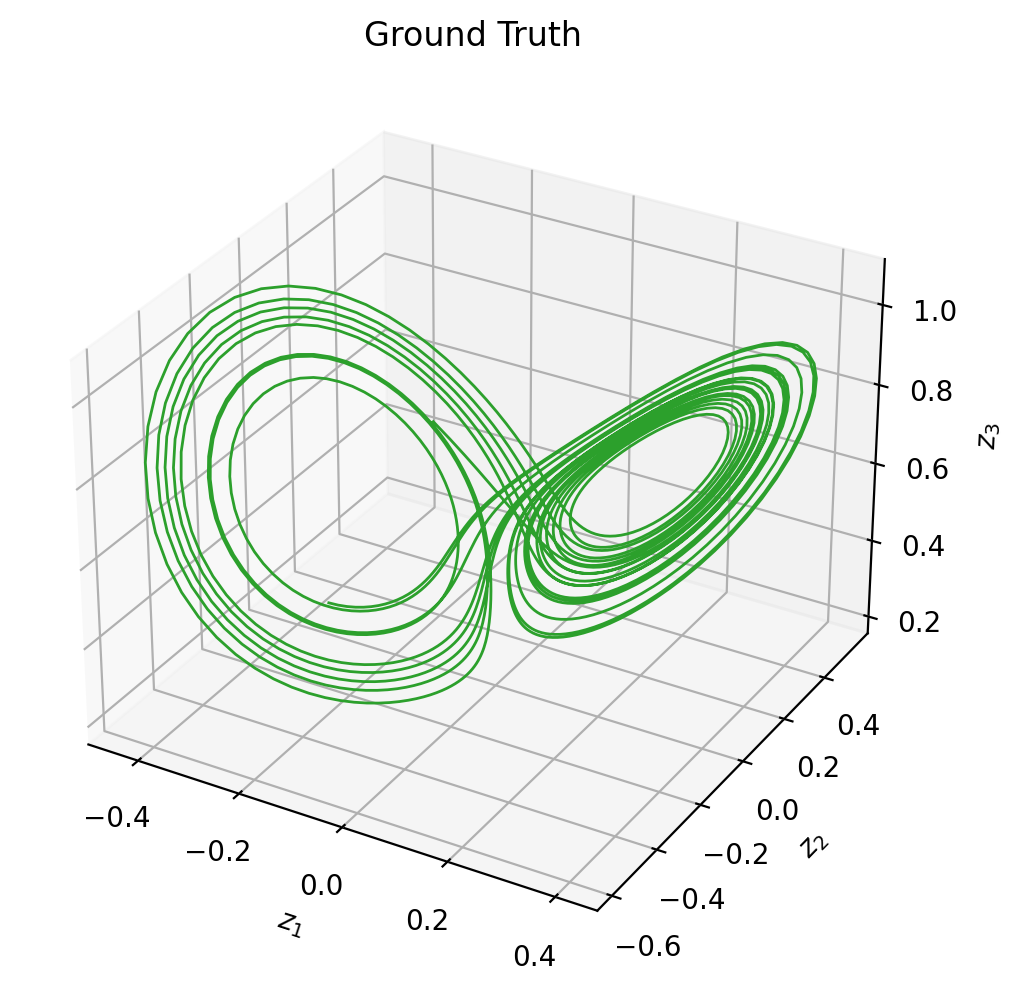

In [12]:
fig = plt.figure(figsize=(6, 6), dpi=200)
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot(lsim[:,0], lsim[:,1], lsim[:,2], linewidth=1, color='tab:green');
ax.set_xlabel(r'$z_1$'); ax.set_ylabel(r'$z_2$'); ax.set_zlabel(r'$z_3$'); ax.set_title('Ground Truth');